# UK Property Image Classification
### EDA model 5c

---

In [1]:
model_tag = "model5c"
label = "new"  # new (period vs modern), or ext (interior vs exterior)

root = "../"
min_size = 300

#### Data:
- Classifying period vs modern, 500 images each class
- Both interior and exterior images
- Unique, non-repetitive image based on hash values

#### Model:
- Convolutional Neural Networks
- Use standard scaler
- Use early stopper based on min val_loss
- Use dropout

#### Grid Search CV:
Grid of parameters:
- Pooling Filter: 3x3, 7x7, 11x11
- Number of neurons in the densely connected layer: 64,128
- Dropout: 0.5, 0.7

Best parameters: Pooling Filter 7x7, No. of Neurons: 128, Dropout: 0.7

#### Model results:
- AUC = 78%
- Accuracy = 71%

### Importing libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from math import ceil
import random

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from skimage import io
from skimage import color
from skimage.transform import rescale, resize

import pickle

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [4]:
# For reproducibility
np.random.seed(42)

In [5]:
import sys
sys.path.insert(0, '../common')
from myfunctions import *
#from myfunctions import hello_world, load_files, load_array, image_std_train, image_std_test, load_train_val, display_images

#### Load the training data - period buildings

In [6]:
#default csv file of image record
file = root + 'data/images_train_val.csv'

# new = 0 refers to the images of period/old building
# repeated = 1 refers to the first images ie not a duplicate
criteria = {"new":0., "repeated":1}

k = 500

# dataframe of labels = 0
df_selected0 = load_train_val(file, criteria, k)

In [7]:
print(df_selected0.shape)
df_selected0.head()

(500, 5)


,image_link,hash,repeated,ext,new
index,,,,,
1373,../images/old_more/photo-14614588-aFfAR0.jpg,fffff9f480000000,1,1,0
1720,../images/old_more/photo-14685497-OmSqXM.jpg,fffffffee0c00c0c,1,0,0
2075,../images/old_more/photo-14719594-1niicx.jpg,f2ff7fff7b436440,1,0,0
2010,../images/old_more/photo-14716964-b6cKe8.jpg,ffffffcf47408003,1,0,0
1988,../images/old_more/photo-14714791-7bNSWu.jpg,ff5e4e4e02627c7c,1,0,0


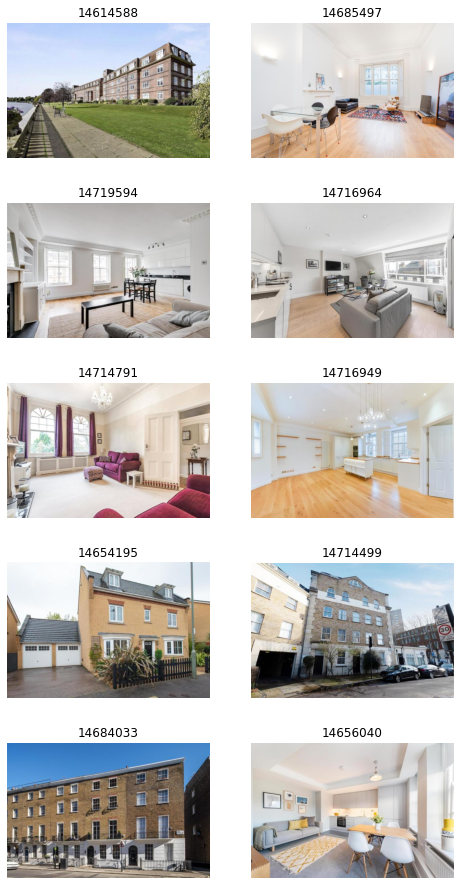

In [8]:
display_no = 10
df_file_info = df_selected0

display_images(display_no, df_file_info)

#### Load the training data - modern buildings

In [9]:
#default csv file of image record
file = root + 'data/images_train_val.csv'

# new = 1 refers to the images of modern building
# repeated = 1 refers to the first images ie not a duplicate
criteria = {"new":1., "repeated":1}

k = 500

# dataframe of labels = 1
df_selected1 = load_train_val(file, criteria, k)

In [10]:
print(df_selected1.shape)
df_selected1.head()

(500, 5)


,image_link,hash,repeated,ext,new
index,,,,,
1129,../images/modern_samples/photo-14612758-sQEDoX...,ff7f3fe707030180,1,0,1
831,../images/modern_more/photo-14705056-6hqAyd.jpg,101819387dfff670,1,1,1
675,../images/modern_more/photo-14692813-8V1MCY.jpg,fffdf1f98100c3e3,1,0,1
218,../images/modern_more/photo-14636571-3vZ5mr.jpg,fffeffefc48c0020,1,0,1
414,../images/modern_more/photo-14658325-2Y42Au.jpg,7ff9fa1800186868,1,0,1


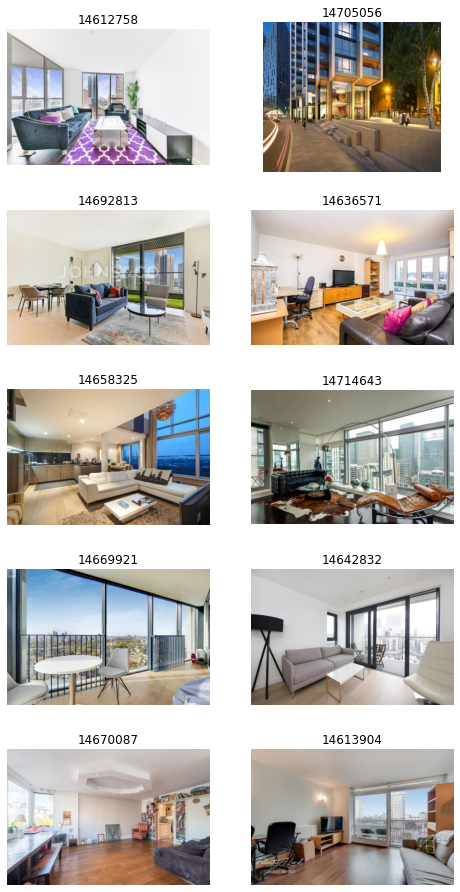

In [11]:
display_no = 10
df_file_info = df_selected1

display_images(display_no, df_file_info)

#### Loading training data into dataframe

In [12]:
# consolidating files of labels 0 and 1
df_all = pd.concat([df_selected0, df_selected1])
df_all.reset_index(drop=True, inplace=True)
df_all["id"] = df_all.index

# loading images into array
X = load_array(df_all["image_link"], min_size)

c:\python37\lib\site-packages\PIL\TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


In [13]:
# recording relevant link and labels
df_y = df_all[["id", "image_link", label]]
df_y.rename(columns={label:"label"}, inplace=True)

print(df_y.shape)
df_y.head(5)

(1000, 3)


c:\python37\lib\site-packages\pandas\core\frame.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,id,image_link,label
0,0,../images/old_more/photo-14614588-aFfAR0.jpg,0
1,1,../images/old_more/photo-14685497-OmSqXM.jpg,0
2,2,../images/old_more/photo-14719594-1niicx.jpg,0
3,3,../images/old_more/photo-14716964-b6cKe8.jpg,0
4,4,../images/old_more/photo-14714791-7bNSWu.jpg,0


#### Train test split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, df_y, stratify=df_y["label"])
print(y_train.shape)

(750, 3)


In [15]:
# Baseline accuracy - 50%
y_train['label'].value_counts()

1    375
0    375
Name: label, dtype: int64

In [16]:
y_test.shape

(250, 3)

In [17]:
y_test['id'][:10]

205    205
191    191
105    105
166    166
14      14
71      71
600    600
273    273
992    992
216    216
Name: id, dtype: int64

#### Check if the first row of X_train and y_train refer to the same image

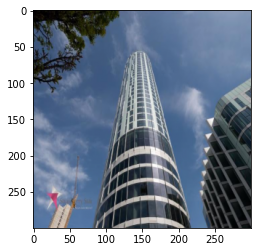

In [18]:
plt.imshow(X_train[0])

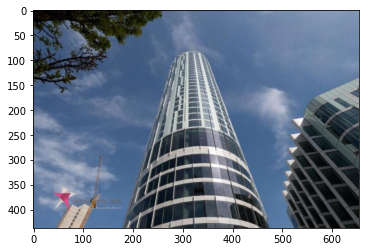

In [19]:
plt.imshow(io.imread(y_train.iloc[0,1]))

#### Standard Scaler

In [20]:
ss, X_train_ss = image_std_train(X_train)

(750, 270000)
(750, 300, 300, 3)


In [21]:
X_test_ss = image_std_test(X_test, ss)

### CNN model

In [22]:
# function to create a keras CNN model based on parameters
# Variables to be declared:
# min_size: photos will be resized to squares with such number of pixels each size: 300, 400
# pool_size: 3, 5, 7, 9, 11
# dropout: 0.5, 0.7
# dense_layer_neurons: 64, 128

def create_model(min_size, pool_size, dense_layer_neurons, dropout):
    model = Sequential()
    model.add(Conv2D(filters = 6,            # number of filters
                         kernel_size = 3,        # height/width of filter
                         activation='relu',      # activation function 
                         input_shape=(min_size,min_size,3))) # shape of input (image)
    model.add(MaxPooling2D(pool_size=(pool_size,pool_size))) # dimensions of region of pooling
    model.add(Conv2D(16, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(pool_size,pool_size)))
    model.add(Flatten())
    model.add(Dense(dense_layer_neurons, activation='relu'))
    model.add(Dropout(dropout))
    # Add a final layer with 1 neuron
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])
    
    print(model.summary())
    
    return model

In [23]:
# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
# GridCVSearch parameters
parameters = {"min_size":[300], "pool_size":[3,7,11], "dense_layer_neurons":[64,128], "dropout":[0.5, 0.7]}

In [24]:
model = KerasClassifier(build_fn=create_model, verbose=0)
grid = GridSearchCV(estimator=model, param_grid=parameters, n_jobs=1, cv=2)
grid_result = grid.fit(X_train_ss,
                        y_train['label'],
                        batch_size=20,
                        validation_data=(X_test_ss, y_test['label']),
                        epochs=10,
                        callbacks=[es],
                        verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 6)       168       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 16)        880       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1048640   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0

Epoch 8/10
19/19 [==============================] - 6s 321ms/step - loss: 0.6407 - accuracy: 0.6281 - val_loss: 0.6556 - val_accuracy: 0.6560
Epoch 9/10
19/19 [==============================] - 6s 315ms/step - loss: 0.6296 - accuracy: 0.6495 - val_loss: 0.6497 - val_accuracy: 0.6600
Epoch 10/10
19/19 [==============================] - 6s 319ms/step - loss: 0.6311 - accuracy: 0.6627 - val_loss: 0.6513 - val_accuracy: 0.6520
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 298, 298, 6)       168       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 99, 99, 6)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 97, 97, 16)        880       
_________________________________________________________________
max_pooling2d_13 (MaxPo

Epoch 3/10
19/19 [==============================] - 6s 318ms/step - loss: 0.7138 - accuracy: 0.5154 - val_loss: 0.6808 - val_accuracy: 0.5840
Epoch 4/10
19/19 [==============================] - 6s 323ms/step - loss: 0.7006 - accuracy: 0.5235 - val_loss: 0.6803 - val_accuracy: 0.5760
Epoch 5/10
19/19 [==============================] - 6s 324ms/step - loss: 0.6743 - accuracy: 0.5524 - val_loss: 0.6754 - val_accuracy: 0.5560
Epoch 6/10
19/19 [==============================] - 6s 334ms/step - loss: 0.6725 - accuracy: 0.5535 - val_loss: 0.6679 - val_accuracy: 0.6400
Epoch 7/10
19/19 [==============================] - 6s 324ms/step - loss: 0.6745 - accuracy: 0.6064 - val_loss: 0.6631 - val_accuracy: 0.6320
Epoch 8/10
19/19 [==============================] - 6s 329ms/step - loss: 0.6597 - accuracy: 0.6010 - val_loss: 0.6588 - val_accuracy: 0.6480
Epoch 9/10
19/19 [==============================] - 6s 332ms/step - loss: 0.6569 - accuracy: 0.6331 - val_loss: 0.6610 - val_accuracy: 0.5920
Epoch 

Epoch 1/10
19/19 [==============================] - 15s 566ms/step - loss: 0.8582 - accuracy: 0.4978 - val_loss: 0.6887 - val_accuracy: 0.5480
Epoch 2/10
19/19 [==============================] - 6s 301ms/step - loss: 0.6721 - accuracy: 0.6081 - val_loss: 0.6824 - val_accuracy: 0.5800
Epoch 3/10
19/19 [==============================] - 6s 339ms/step - loss: 0.6549 - accuracy: 0.6475 - val_loss: 0.7370 - val_accuracy: 0.5080
Epoch 4/10
19/19 [==============================] - 7s 349ms/step - loss: 0.6425 - accuracy: 0.6155 - val_loss: 0.6581 - val_accuracy: 0.5960
Epoch 5/10
19/19 [==============================] - 6s 327ms/step - loss: 0.6243 - accuracy: 0.6233 - val_loss: 0.6495 - val_accuracy: 0.6240
Epoch 6/10
19/19 [==============================] - 6s 327ms/step - loss: 0.6070 - accuracy: 0.6490 - val_loss: 0.6368 - val_accuracy: 0.6360
Epoch 7/10
19/19 [==============================] - 6s 331ms/step - loss: 0.5475 - accuracy: 0.7752 - val_loss: 0.7345 - val_accuracy: 0.6040
Epoch

Epoch 1/10
19/19 [==============================] - 12s 567ms/step - loss: 0.6937 - accuracy: 0.5536 - val_loss: 0.6803 - val_accuracy: 0.5560
Epoch 2/10
19/19 [==============================] - 5s 276ms/step - loss: 0.7331 - accuracy: 0.4926 - val_loss: 0.6816 - val_accuracy: 0.5640
Epoch 3/10
19/19 [==============================] - 6s 338ms/step - loss: 0.6740 - accuracy: 0.5850 - val_loss: 0.6788 - val_accuracy: 0.5960
Epoch 4/10
19/19 [==============================] - 6s 328ms/step - loss: 0.6649 - accuracy: 0.5693 - val_loss: 0.6682 - val_accuracy: 0.5880
Epoch 5/10
19/19 [==============================] - 6s 340ms/step - loss: 0.6334 - accuracy: 0.6575 - val_loss: 0.6756 - val_accuracy: 0.5880
Epoch 6/10
19/19 [==============================] - 7s 352ms/step - loss: 0.6468 - accuracy: 0.6022 - val_loss: 0.6625 - val_accuracy: 0.6240
Epoch 7/10
19/19 [==============================] - 7s 367ms/step - loss: 0.6261 - accuracy: 0.6450 - val_loss: 0.6599 - val_accuracy: 0.6000
Epoch

Epoch 1/10
19/19 [==============================] - 9s 444ms/step - loss: 0.9083 - accuracy: 0.4519 - val_loss: 0.6772 - val_accuracy: 0.5560
Epoch 2/10
19/19 [==============================] - 5s 247ms/step - loss: 0.6953 - accuracy: 0.5425 - val_loss: 0.6651 - val_accuracy: 0.6120
Epoch 3/10
19/19 [==============================] - 6s 308ms/step - loss: 0.6322 - accuracy: 0.6734 - val_loss: 0.6489 - val_accuracy: 0.6280
Epoch 4/10
19/19 [==============================] - 6s 321ms/step - loss: 0.6264 - accuracy: 0.6559 - val_loss: 0.6288 - val_accuracy: 0.6680
Epoch 5/10
19/19 [==============================] - 6s 316ms/step - loss: 0.5935 - accuracy: 0.7176 - val_loss: 0.6163 - val_accuracy: 0.6640
Epoch 6/10
19/19 [==============================] - 6s 323ms/step - loss: 0.5851 - accuracy: 0.6893 - val_loss: 0.6310 - val_accuracy: 0.6720
Epoch 7/10
19/19 [==============================] - 6s 347ms/step - loss: 0.5558 - accuracy: 0.7210 - val_loss: 0.5997 - val_accuracy: 0.6960
Epoch 

Epoch 1/10
19/19 [==============================] - 16s 792ms/step - loss: 0.8063 - accuracy: 0.4682 - val_loss: 0.6948 - val_accuracy: 0.5200
Epoch 2/10
19/19 [==============================] - 5s 263ms/step - loss: 0.7471 - accuracy: 0.5008 - val_loss: 0.6873 - val_accuracy: 0.5400
Epoch 3/10
19/19 [==============================] - 6s 318ms/step - loss: 0.7048 - accuracy: 0.5274 - val_loss: 0.6879 - val_accuracy: 0.5320
Epoch 4/10
19/19 [==============================] - 6s 319ms/step - loss: 0.6907 - accuracy: 0.5274 - val_loss: 0.6838 - val_accuracy: 0.5480
Epoch 5/10
19/19 [==============================] - 6s 309ms/step - loss: 0.6784 - accuracy: 0.5508 - val_loss: 0.6798 - val_accuracy: 0.5920
Epoch 6/10
19/19 [==============================] - 6s 319ms/step - loss: 0.6784 - accuracy: 0.5638 - val_loss: 0.6767 - val_accuracy: 0.5840
Epoch 7/10
19/19 [==============================] - 6s 313ms/step - loss: 0.6551 - accuracy: 0.6053 - val_loss: 0.6672 - val_accuracy: 0.6280
Epoch

In [25]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.681333 using {'dense_layer_neurons': 128, 'dropout': 0.7, 'min_size': 300, 'pool_size': 7}
0.678667 (0.012000) with: {'dense_layer_neurons': 64, 'dropout': 0.5, 'min_size': 300, 'pool_size': 3}
0.613333 (0.029333) with: {'dense_layer_neurons': 64, 'dropout': 0.5, 'min_size': 300, 'pool_size': 7}
0.626667 (0.013333) with: {'dense_layer_neurons': 64, 'dropout': 0.5, 'min_size': 300, 'pool_size': 11}
0.665333 (0.052000) with: {'dense_layer_neurons': 64, 'dropout': 0.7, 'min_size': 300, 'pool_size': 3}
0.646667 (0.004000) with: {'dense_layer_neurons': 64, 'dropout': 0.7, 'min_size': 300, 'pool_size': 7}
0.649333 (0.049333) with: {'dense_layer_neurons': 64, 'dropout': 0.7, 'min_size': 300, 'pool_size': 11}
0.638667 (0.030667) with: {'dense_layer_neurons': 128, 'dropout': 0.5, 'min_size': 300, 'pool_size': 3}
0.676000 (0.030667) with: {'dense_layer_neurons': 128, 'dropout': 0.5, 'min_size': 300, 'pool_size': 7}
0.668000 (0.001333) with: {'dense_layer_neurons': 128, 'dropout': 0.5, 'm

In [26]:
# fitting the model with the best params

print(grid_result.best_params_)
model = create_model(**grid_result.best_params_)
history = model.fit(X_train_ss,
                        y_train['label'],
                        batch_size=20,
                        validation_data=(X_test_ss, y_test['label']),
                        epochs=10,
                        callbacks=[es],
                        verbose=1)

{'dense_layer_neurons': 128, 'dropout': 0.7, 'min_size': 300, 'pool_size': 7}
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 298, 298, 6)       168       
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 42, 42, 6)         0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 40, 40, 16)        880       
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 400)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 128)               51328     
_________________________________________

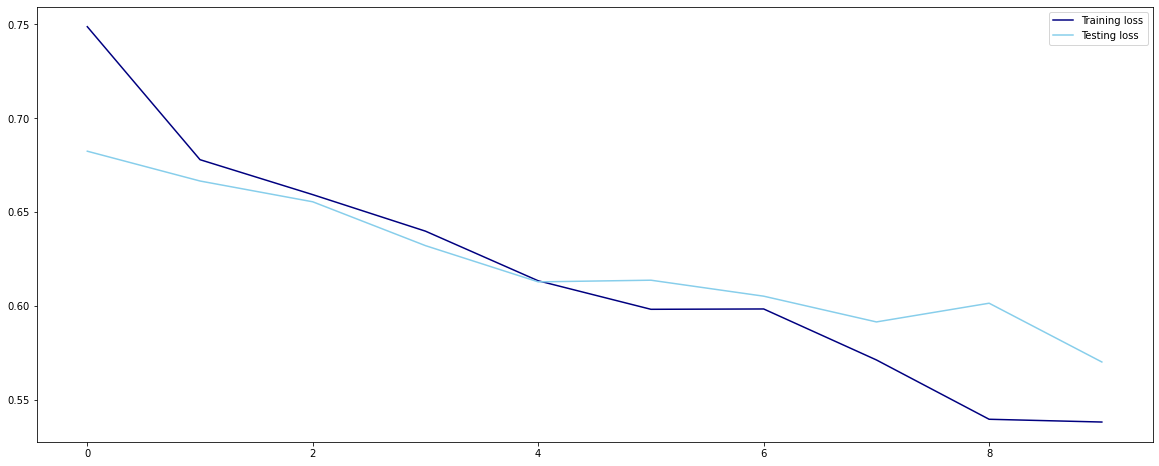

In [27]:
# plot the changes in loss function values
train_loss = history.history['loss']
test_loss = history.history['val_loss']
plt.figure(figsize=(20, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

#### Predictions based on the model

In [28]:
y_pred = model.predict(X_test_ss)


In [29]:
y_pred.shape

(250, 1)

#### Area under Curve

In [30]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test["label"], y_pred)
auc_keras = auc(fpr_keras, tpr_keras)

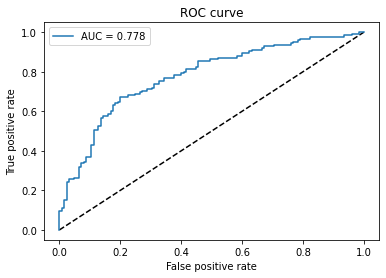

In [31]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='AUC = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

#### List out the images of misclassification - test images

In [32]:
y_test['pred'] = y_pred.round()
y_test['prob'] = y_pred.round(2)
y_test.head(10)

c:\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,image_link,label,pred,prob
205,205,../images/old_more/photo-14719583-i8mT7L.jpg,0,0.0,0.24
191,191,../images/old_more/photo-14673865-UDQfRk.jpg,0,0.0,0.31
105,105,../images/old_more/photo-14680257-Jgujkw.jpg,0,0.0,0.43
166,166,../images/old_interior/photo-14614838-WF1sMz.jpg,0,0.0,0.15
14,14,../images/old_more/photo-14718224-bOSbfg.jpg,0,1.0,0.60
71,71,../images/old_more/photo-14649564-qHvdKD.jpg,0,1.0,0.87
600,600,../images/old_more/photo-14714296-gjt7Xr.jpg,1,0.0,0.44
273,273,../images/old_samples/photo-14756292-Akmpn7.jpg,0,0.0,0.46
992,992,../images/modern_more/photo-14714983-STBzkL.jpg,1,1.0,0.55
216,216,../images/old_more/photo-14689484-GFBm7A.jpg,0,0.0,0.31


In [33]:
def display_predictions(display_no, df_file_info):
    # displaty_no: must be multiples of 10
    # df: must have "image_link" as a field

    display_height = display_no/10*16

    fig, ax = plt.subplots(ceil(display_no/2), 2, figsize=(8,display_height))
    j=0
    for i in df_file_info.index[:min(display_no, df_file_info.shape[0])]:
        row = j//2
        col = j%2
        image_link = df_file_info.loc[i, "image_link"]
        property_id = re.findall('[0-9]{3}[0-9]+',image_link)[0]
        ax[row][col].imshow(io.imread(image_link))
        ax[row][col].axis('off')
        ax[row][col].set_title(property_id + ", label:" + str(df_file_info.loc[i, "label"]) + ", pred:" + str(df_file_info.loc[i, "pred"]) + ", prob:"  + str(round(df_file_info.loc[i, "prob"],2)))
        j += 1


#### Images properly classified

In [34]:
# count the number of photos classified properly in y_test
y_test_classified = y_test[["image_link", "label", "pred", "prob"]][y_test["label"] == y_test["pred"]]

print(f"total number in y_test: {y_test.shape[0]}")
print(f"classified properly in y_test: {y_test_classified.shape[0]}")
y_test_classified.head()

print(f"accuracy: {round(y_test_classified.shape[0]/y_test.shape[0],2)}")


total number in y_test: 250
classified properly in y_test: 177
accuracy: 0.71
